# RADIA Example 3: Simple Dipole Magnet

This example concerns geometries dominated by iron.

The field computation with Radia in the case of iron dominated geometries 
presents a few specific difficulties and is usually less accurate than 
in the case of coil or permanent magnet dominated structure. Nevertheless, 
special methods have been developed to reach a reasonable precision within 
a reasonable CPU time and memory. 
The example below is that of a simple dipole steerer made of a closed circuit 
of iron with a small gap and a coil wounded around the circuit that drives 
some flux in the iron (see the graphics below). This example is more delicate 
than all previous examples and we advise the beginner to first get experienced 
with them before diving into this one. 
Among the most important things to remember if one wants to reach a good 
precision in a reasonable time are: 
- Always segment the corners of the iron circuits as parallel or perpendicular 
to the flux line as possible. For right angle corners, this can be done with 
the circular or ellipsoidal mode of segmentation (see below). 
This is extremely important. 
In this example, we make use of the circular segmentation twice (the other 
two corners are segmented similarly by symmetry) it is made in the section 
entitled "Defining the Model" when calling 
  "rad.ObjDivMag(g3,[nbr,nbp,n3[1]],\'cyl\',typ)" and 
  "rad.ObjDivMag(g5,[nbr,nbp,n5[0]],\'cyl\',typ)". 
- Use a narrower segmentation on the iron faces close to the region 
of interest. 
- Start with low segmentation numbers and increase them gradually to check that 
the field is stable. Beware that the memory and cpu time tends to grow like 
the square number of elements. 
- Use symmetries as much as possible. It saves both memory and CPU time. 
The steerer dipole shown below has a symmetry of order 2 x 2. 16 times more 
memory and 4 times more CPU time would have been needed without using 
the symmetries. 

This example concerns the geometries dominated by iron. At any point in space one can consider that the magnetic field is the sum of two  contributions. One comes from the real sources of magnetic field such as coils or permanent magnets. The other comes from the iron  through its magnetization. Even though the magnetization of the iron is induced by  the coils or permanent magnets, its field contribution to the point of interest can be much larger than the direct contribution form coils and magnets. We call these geometries “Iron Dominated”, electro-magnet dipole and quadrupole used in particle accelerators fall into this category. Most of undulators and wigglers used as synchrotron radiation sources do not fall into this category. The field computation with Radia in the case of Iron Dominated geometries presents a few specific difficulties and is usually less accurate than in the case of coil or permanent magnet dominated structure. Nevertheless, special methods have been developed to  reach a reasonable precision within a reasonable cpu time and memory. The example below is that of a simple dipole steerer made of a closed circuit of iron with a small gap and a coil wounded around the circuit that drives some flux in the iron (see the graphics below). This example is more delicate than all  previous examples and we advise the beginner to first get experienced with them before diving into this one. 
Among the most important things to remember if one wants to  reach a good precision in a reasonable time are :
- Always segment the corners of the iron circuits as parallel or perpendicular to the flux line as possible. For right angle corners, this can be done with the circular or ellipsoidal mode of segmentation (see below). This is extremely important. In this example, we make use of the circular segmentation twice (the other two corners are segmented similarly by symmetry) it is made in the section entitled  "Defining the Model" when calling  "radObjDivMag[g3,{nbr,nbp,n3[[1]]},typ]" and  "radObjDivMag[g5,{nbr,nbp,n5[[1]]},typ]". 
- Use a narrower segmentation on the iron faces close to the region of interest .
- Start with low segmentation numbers and increase them gradually to check that the field is stable. Beware that the memory and cpu time tends to grow like the square number of elements. 
- Use symmetries as much as possible. It saves both memory and CPU time. The steerer dipole shown below has a symmetry of order 2 x 2.  16 times more memory and 4 times more cpu time would have been needed without using the symmetries. 
As for the previous examples, try to modify some parameters (see the Reference Guide for the explanations on all Radia functions) and re-execute the corresponding section. All sections must be evaluated in the order of presentation. A section may be evaluated several times with the same or different parameters if the previous sections have been evaluated before. The only limitation is memory. The Radia.exe memory can be re-initialized by re-executing the section entitled "Load and Initialize Radia". The Kernel memory can be re-initialized by executing Exit[] and then re-executing all sections of this example. If the Front-End is running out of memory, close some windows or close the Front-End and start it again. Note that if by mistake any section is executed before the previous ones are executed, it may be necessary to exit the Kernel and re-start everything from the very beginning. The maximum precision requires large memory and long cpu time and ultimately, you may want to add extra memory to your computer. However remember that the memory required tends to be proportional to the square number of sub-elements and increasing the segmentation by 2 in all three directions results in 8 times more sub-elements and 64 times more memory. Consequently, one should increase the segmentation number in some "intelligent" manner ,  this requires a bit of experience. One way to  develop this skill is to  watch the precision following an  increase of  the segmentation in one object and one plane at a time . By this method, one quickly  identifies the objects and the directions which require more segmentation to improve the accuracy.

One can also—for undulators such as this one—compute field integrals and forces
on the magnets and poles. In addition, one can build a wedge-pole undulator by
using polyhedrons or extruded polygons instead of rectangular blocks. To learn
more, read the [Radia documentation](
  https://www.esrf.eu/Accelerators/Groups/InsertionDevices/Software/Radia/Documentation
  "RADIA documentation at ESRF"),
experiment with the code, and develop experience.

## _Import Radia and other packages_

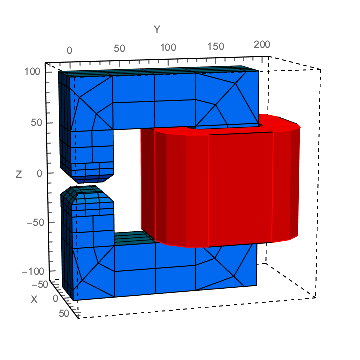

In [2]:
%matplotlib inline
from __future__ import division, print_function #Py 2.*/3.* compatibility
import radia as rad
import numpy as np
import matplotlib.pyplot as plt
import time as tm
import scipy.constants as sc

# until we have 3D graphics, simply
# import an illustration of this magnet
from IPython.display import Image
Image(filename=('./SimpleDipole.png'))

## _Define function to build the undulator_

We here define a function that constructs the desired undulator geometry in Radia.
It constructs in Radia an array of rectangular permanent magnets and iron blocks,
each with given dimensions, magnetization, segmentation, material properties,
and colors (for plotting). It then constructs their mirror symmetric counterparts.
The function is generic and can be used to build almost any hybrid undulator—though
without optimizing the design of terminations.

In [ ]:
def undulator(lp, mp, np, cp,  lm, mm, nm, cm,  gap, gapOffset, numPer):
    """
    create hybrid undulator magnet
    arguments:
      lp = [lpx, lpy, lpz] = dimensions of the iron poles / mm
      mp = magnetic properties of the iron poles (M-H curve)
      np = segmentation of the iron poles
      cp = [r,g,b] = color for the iron poles
      lm = [lmx, lmy, lmz] = dimensions of the magnet blocks / mm
      mm = magnetic properties of the magnet blocks (remanent magnetization)
      nm = segmentation of the magnet blocks
      cm = [r,g,b] = color for the magnet blocks
      gap = undulator gap / mm
      gapOffset = vertical offset / mm of the magnet blocks w/rt the poles
      numPer = number of full periods of the undulator magnetic field
    return: Radia representations of
      undulator group, poles, permanent magnets
    """
    zer = [0,0,0]

    # full magnet will be assembled into this Radia group
    grp = rad.ObjCnt([])

    # principal poles and magnet blocks in octant(+,+,–)
    # -- half pole
    y = lp[1]/4
    pole = rad.ObjFullMag([lp[0]/4,    y,    -lp[2]/2 - gap/2],
                          [lp[0]/2, lp[1]/2,  lp[2]          ], zer, np, grp, mp, cp)
    y += lp[1]/4
    # -- magnet and pole pairs
    mDir = -1
    for i in range(0, numPer):
        initM = [0, mDir, 0]; mDir *= -1
        y += lm[1]/2
        magnet = rad.ObjFullMag([lm[0]/4,   y,   -lm[2]/2 - gap/2 - gapOffset],
                                [lm[0]/2, lm[1],  lm[2]                      ], initM, nm, grp, mm, cm)
        y += (lm[1] + lp[1])/2
        pole = rad.ObjFullMag([lp[0]/4,   y,   -lp[2]/2 - gap/2],
                              [lp[0]/2, lp[1],  lp[2]          ], zer, np, grp, mp, cp)
        y += lp[1]/2
    # -- end magnet block
    initM = [0, mDir, 0]
    y += lm[1]/4;
    magnet = rad.ObjFullMag([lm[0]/4,   y,     -lm[2]/2 - gap/2 - gapOffset],
                            [lm[0]/2, lm[1]/2,  lm[2]                      ], initM, nm, grp, mm, cm)

    # use mirror symmetry to define the full undulator
    rad.TrfZerPerp(grp, zer, [1,0,0]) # reflect in the (y,z) plane
    rad.TrfZerPara(grp, zer, [0,0,1]) # reflect in the (x,y) plane
    rad.TrfZerPerp(grp, zer, [0,1,0]) # reflect in the (z,x) plane
    
    return grp, pole, magnet

## _Define functions for the magnetic materials and fields_

The first of the following functions returns a Radia representation of the magnetization curves _M_ (in Tesla) vs _H_ (in Amp/m) for both the pole tips and the magnets. The material for the poles is defined by calling the function `rad.MatSatIsoTab` with the data table `ma`, which contains the paired values of _H_ and _M_, both expressed in Tesla. (The conversion of _H_ in Amp/m to Tesla is accomplished simply by multiplying _H_ by _μ<sub>o</sub>_, i.e. `4*pi/10^7`.) The material for the permanent magnets is defined by calling `rad.MatStd`, with arguments _material type_ and _remanent magnetization_. We will later plot the resulting _M_(_H_) curves for verification.

The next function extracts magnetic field information from a given magnetic material defined by Radia. This allows us to plot the _M_(_H_) curves tocompare with our input data. And the third function calculates (for a _solved_ Radia magnet) the vertical field along the Y (longitudinal) axis.

In [ ]:
# magnetic constant (vacuum magnetic permeability)
mu0 = 4 * np.pi / 1e7

def materials(H, M,  smat, rm):
    """
    define magnetic materials for the undulator poles and magnets
    arguments:
      H    = list of magnetic field values / (Amp/m)
      M    = corresponding magnetization values / T
      smat = material type string
      rm   = remanent magnetization / T
    return: Radia representations of ...
      pole-tip material, magnet material
    """
    # -- magnetic property of poles
    #convH = 4. * np.pi / 1.0e7
    ma = [[mu0 * H[i], M[i]] for i in range(len(H))]
    mp = rad.MatSatIsoTab(ma)
    # -- permanent magnet material
    mm = rad.MatStd(smat, rm)

    return mp, mm


def getMagnMaterCompMvsH(meshH, ind, cmpnH,  cmpnM):
    """
    extract magnetization M_comp vs field strength H_comp from material data
    arguments:
      meshH = how to mesh the H axis: [hmin, hmax, nh]
      ind   = magnet material index
      cmpnH = component of H ('x', 'y', or 'z')
      cmpnM = component of M ('x', 'y', or 'z')
    return:
      given component of magnetization along the given mesh in H
    """
    hMin = meshH[0]; hMax = meshH[1]; nh = meshH[2]
    hStep = (hMax - hMin) / (nh - 1)
    m = [ 0 ] * nh
    sCmpnM = 'm' + cmpnM
    h = hMin
    H = [0,0,0]
    for i in range(nh):
        if(  cmpnH == 'x'): H[0] = h
        elif(cmpnH == 'y'): H[1] = h
        elif(cmpnH == 'z'): H[2] = h
        m[i] = rad.MatMvsH(ind, sCmpnM, H)
        h += hStep
    return m


def calcField(grp, per, numPer):
    """
    compute vertical magnetic field vs longitudinal position (Y)
    arguments:
      grp    = magnet (Radia group)
      per    = period / mm
      numPer = number of full magnetic periods
    return:
      Bz(y), meshY
    """
    xc = 0 # transverse X coordinate
    zc = 0 # transverse Z coordinate
    yMax = per * (numPer + 1) / 2.
    yMin = -yMax
    ny = 501
    yStep = (yMax - yMin) / ny
    y = np.arange(yMin, yMin + ny * yStep, yStep)
    
    points = [[xc, yi, zc] for yi in y]
    BzVsY = rad.Fld(grp, 'bz', points)

    return BzVsY, [yMin, yMax, ny]

## _Create the undulator magnet_

First enter and plot the data describing the magnetization curve for the iron pole tips.

In [ ]:
# ~iron type Va Permendur
ironH = [  0.8,   1.5,     2.2,    3.6,    5.0,     6.8,     9.8,    18.0,
          28.0,   37.5,   42.0,   55.0,   71.5,    80.0,    85.0,    88.0,
          92.0,  100.0,  120.0,  150.0,  200.0,   300.0,   400.0,   600.0,
         800.0, 1000.0, 2000.0, 4000.0, 6000.0, 10000.0, 25000.0, 40000.0]
ironM = [0.000998995, 0.00199812, 0.00299724, 0.00499548, 0.00699372, 0.00999145, 0.0149877, 0.0299774,
         0.0499648,   0.0799529,  0.0999472,  0.199931,   0.49991,    0.799899,   0.999893, 1.09989,
         1.19988,     1.29987,    1.41985,    1.49981,    1.59975,    1.72962,    1.7995,   1.89925,
         1.96899,     1.99874,    2.09749,    2.19497,    2.24246,    2.27743,    2.28958,  2.28973]

# full M-H curve
plt.figure(figsize=(7,4.3))
plt.plot([mu0 * h for h in ironH], ironM)
plt.title(r'Magneteization Curve $M(H)$')
plt.xlabel(r'$\mu_o H$ / T')
plt.ylabel(r'$M$ / T')
plt.grid()
plt.show()

# leading edge of M-H curve
plt.figure(figsize=(7,4.3))
plt.plot([mu0 * h for h in ironH], ironM)
plt.title(r'Magneteization Curve $M(H)$')
plt.xlabel(r'$\mu_o H$ / T')
plt.ylabel(r'$M$ / T')
plt.xlim([0,0.001])
plt.ylim([0,2.0])
plt.grid()
plt.show()

Then set the magnet parameters and materials, and “build the magnet”.

In [ ]:
# set parameters for this undulator
# -- general parameters
numPer =  2    # number of full magnetic periods
per = 46       # period / mm
gap = 20       # gap height / mm
gapOffset = 1  # 

# -- parameters for the iron poles
lp =  [45,5,25] # dimensions / mm
nsp = [2,2,5]   # pole-tip segmentation (try varying this setting)
cp =  [1,0,1]   # assign color
ll = per/2 - lp[1]

# -- parameters for the magnet blocks
lm  = [65,ll,45] # dimensions / mm
nsm = [1,3,1]    # magnet-block segmentation (try varying this)
cm  = [0,1,1]    # assign color

# -- magnetic materials
# pole tips: ~iron type Va Permendur
# permanent magnets: NdFeB with 1.2 Tesla remanent magnetization
mp, mm = materials(ironH, ironM, 'NdFeB', 1.2)

# then build the undulator
und, pole, magnet = undulator(lp, mp, nsp, cp, lm, mm, nsm, cm, gap, gapOffset, numPer)

Here plot the magnetization curve (extracted from Radia) for the iron pole tips. These should appear identical to the corresponding plots above.

In [ ]:
# full M-H curve
meshH= [0.00, mu0 * ironH[-1], 201]
Mpole = getMagnMaterCompMvsH(meshH, pole, 'y', 'y')

plt.figure(figsize=(7,4.3))
plt.plot(np.linspace(meshH[0],meshH[1],meshH[2]), Mpole)
plt.title(r'Magneteization Curve $M(H)$')
plt.xlabel(r'$\mu_oH$ / T')
plt.ylabel(r'$M$ / T')
plt.grid()
plt.show()

# leading edge of the M-H curve
meshH= [0.000, 0.001, 101]
Mpole = getMagnMaterCompMvsH(meshH, pole, 'y', 'y')

plt.figure(figsize=(7,4.3))
plt.plot(np.linspace(meshH[0],meshH[1],meshH[2]), Mpole)
plt.title(r'Magneteization Curve $M(H)$')
plt.xlabel(r'$\mu_oH$ / T')
plt.ylabel(r'$M$ / T')
plt.xlim([0,0.001])
plt.ylim([0,2.0])
plt.grid()
plt.show()

## _Solve for the undulator magnetization_

Here we ask Radia to solve for the undulator magnetization—_i.e._ for the magnetization within each sub-block that constitutes the undulator—and also report some statistics concerning that solution.

In [ ]:
# solve for the magnetization
prec = 0.0003  # precision for this computation
maxIter = 1000 # maximum allowed iterations
t0 = tm.time()
res = rad.Solve(und, prec, maxIter)
t1 = tm.time()

print("Solved for magnetization in {0:6f} s".format(t1 - t0))
print("Relaxation results")
print("  number of iterations: {0:5d}".format(int(res[3])))
print("  average stability of magnetization at last iteration: {0:.4e} T".format(res[0]))
print("  maximum absolute magnetization at last iteration: {0:.5f} T".format(res[1]))
print("  maximum H vector at last iteration: {0:.5f} T".format(res[2]))
print("Peak magnetic field: {0:.8f} T".format(rad.Fld(und, 'bz', [0,0,0])))

Now ask Radia to compute the magnetic field along the undulator’s longitudinal axis. And then plot the results.

In [ ]:
# compute magnetic field values
t2 = tm.time()
BzVsY, MeshY = calcField(und, per, numPer)
t3 = tm.time()
print("Computed requested field vaues in {0:6f} s\n".format(t3 - t2))

# and plot
y = np.linspace(MeshY[0], MeshY[1], MeshY[2])
plt.figure(figsize=(7,4.3))
plt.plot(y, BzVsY, linewidth = 2.0)
plt.title(r"Vertical Magnetic Field, $B_z$, along undulator's $y$ axis")
plt.xlabel('y / mm')
plt.ylabel('$B_z$ / T')
plt.grid()
plt.show()

## _Check the Material Properties_

Here we extract from Radia, and plot, the magnetization curve—magnetization _vs._ field strength—of the pole tip material.

In [ ]:
# extract data for the pole tip material
meshH_pole = [-0.0012, 0.0012, 201]
M_pole = getMagnMaterCompMvsH(meshH_pole, pole, 'z', 'z')

# and plot that data
h = np.linspace(1e3*meshH_pole[0], 1e3*meshH_pole[1], meshH_pole[2])
plt.figure(figsize=(7,4.3))
plt.plot(h, M_pole, linewidth = 2.0)
plt.title(r'Magnetization Curve $M(H)$ for pole material')
plt.xlabel('magnetic field strength $\mu_0 H$ / mT')
plt.ylabel('magnetization $M$ / T')
plt.grid()
plt.show()

# do this again over a wider range of H values
meshH_pole = [-0.01, 0.01, 201]
M_pole = getMagnMaterCompMvsH(meshH_pole, pole, 'x', 'x')

h = np.linspace(1e3*meshH_pole[0], 1e3*meshH_pole[1], meshH_pole[2])
plt.figure(figsize=(7,4.3))
plt.plot(h, M_pole, linewidth = 2.0)
plt.title(r'Magnetization Curve $M(H)$ for pole material')
plt.xlabel('magnetic field strength $\mu_0 H$ / mT')
plt.ylabel('magnetization $M$ / T')
plt.grid()
plt.show()

In a similar manner, we extract from Radia, and plot, magnetization curves for the permanent magnet material. In this case, the material has a significant anisotropy, as evidenced by the diffferent results parallel and perpendicular to the so-called “easy” axis.

In [ ]:
# extract data for the permanent magnet material
meshH_mag = [-1, 1, 201]
Mpara_mag = getMagnMaterCompMvsH(meshH_mag, magnet, 'y', 'y') # parallel to easY axis
Mperp_mag = getMagnMaterCompMvsH(meshH_mag, magnet, 'x', 'x') # perpendicular to easY axis

# plot parallel result
h = np.linspace(meshH_mag[0], meshH_mag[1], meshH_mag[2])
plt.figure(figsize=(7,4.3))
plt.plot(h, Mpara_mag, linewidth = 2.0)
plt.title(r'Magnetization $M(H)$ parallel to "easy" axis')
plt.xlabel('magnetic field strength $\mu_0 H$ / T')
plt.ylabel('magnetization $M$ / T')
plt.grid()
plt.show()

# plot perpendicular result
plt.figure(figsize=(7,4.3))
plt.plot(h, Mperp_mag, linewidth = 2.0)
plt.title(r'Magnetization $M(H)$ perpendicular to "easy" axis')
plt.xlabel('magnetic field strength $\mu_0 H$ / T')
plt.ylabel('magnetization $M$ / T')
plt.grid()
plt.show()

# plot both results
plt.figure(figsize=(7,4.3))
plt.plot(h, Mpara_mag, linewidth = 2.0)
plt.plot(h, Mperp_mag, linewidth = 2.0)
plt.title(r'$M(H)$ parallel (blue) and perpendicular (orange) to "easy" axis')
plt.xlabel('magnetic field strength $\mu_0 H$ / T')
plt.ylabel('magnetization $M$ / T')
plt.grid()
plt.show()

## _Optimizing Parameters_

In this section, we examine the peak field of the undulator as a function
of the horizontal width of the iron pole tips. This field value is needed
in calculating the fundamental undulator parameter K, given by
$$K = \frac{e B_0 \lambda_u}{2\pi m_e c}.$$
The function `maxField` defined here computes the maximum field for a given
pole width. The other required arguments allow one to vary the segmentation
of both pole-tips and magnet blocks. In the computations that follow, you
will see that the choice of segmentation can have a significant impact on
the accuracy of values computed for $B_0$.

In [ ]:
def maxField(pw, np, nm, prec = 0.0005, maxIter = 1000):
    """
    compute maximum vertical field for given undulator design
    NB: Except for the argument values here, all magnet
        and simulation parameters are as defined above
    arguments:
      pw      = pole width / mm
      np      = segmentation of the iron poles, [nx, ny, nz]
      nm      = segmentation of the magnet blocks
      prec    = precision goal for this computation
      maxIter = maximum allowed iterations
    return: maximum vertical field / T
    """
    rad.UtiDelAll()
    lp0 = lp[0]
    lp[0] = pw
    mp, mm = materials(ironH, ironM, 'NdFeB', 1.2)
    und, pole, magnet = undulator(lp, mp, np, cp, lm, mm, nm, cm, gap, gapOffset, numPer)
    res = rad.Solve(und, prec, maxIter)
    lp[0] = lp0
    return rad.Fld(und, 'bz', [0,0,0])

def undulatorK(b0, wl):
    """
    compute undulator K value
    arguments:
      b0 = peak field / T
      wl = undulator period / m
    return:
      K = (e B_0 \lambda_u) / (2\pi m_e c)
    """
    return sc.e * b0 * wl / (2 * sc.pi * sc.m_e * sc.c)

In [ ]:
undulatorK(0.491812, 46.e-3)

Setting both segmentation arrays to `[1,1,1]` results in a quick, but
inaccurate, computation. Still, this choice gives us a general range to
search for an optimum value of the magnet width.

In [ ]:
pw = np.linspace(4, 60, (14 + 1))
Bmax = [maxField(w, [1,1,1], [1,1,1], prec = 0.0005) for w in pw]

# plot Bmax vs Pole width
plt.figure(figsize=(7,4.3))
plt.plot(pw, Bmax, linewidth = 2.0)
plt.title(r'maximum $B$ field versus pole width')
plt.xlabel('pole width $w$ / mm')
plt.ylabel('$B_\text{max}$ / T')
plt.grid()
plt.show()

We now increase both segmentation arrays, and then compute $B_0$ in a narrower
range of pole-tip widths.

In [ ]:
pw = np.linspace(24, 48, (16 + 1))
Bmax = [maxField(w, [2,2,5], [1,3,1], prec = 0.0003) for w in pw]

# plot Bmax vs Pole width
plt.figure(figsize=(7,4.3))
plt.plot(pw, Bmax, linewidth = 2.0)
plt.title(r'maximum $B$ field versus pole width')
plt.xlabel('pole width $w$ / mm')
plt.ylabel('$B_\text{max}$ / T')
plt.grid()
plt.show()

You can experiment with further increases to the segmentation:

In [ ]:
pw = np.linspace(30, 40, (20 + 1))
Bmax = [maxField(w, [4,4,10], [2,6,2], prec = 0.0001) for w in pw]

# plot Bmax vs Pole width
plt.figure(figsize=(7,4.3))
plt.plot(pw, Bmax, linewidth = 2.0)
plt.title(r'maximum $B$ field versus pole width')
plt.xlabel('pole width $w$ / mm')
plt.ylabel('$B_\text{max}$ / T')
plt.grid()
plt.show()

In [ ]:
pw = np.linspace(36, 40, (16 + 1))
Bmax = [maxField(w, [4,4,10], [2,6,2], prec = 0.0001) for w in pw]

# plot Bmax vs Pole width
plt.figure(figsize=(7,4.3))
plt.plot(pw, Bmax, linewidth = 2.0)
plt.title(r'maximum $B$ field versus pole width')
plt.xlabel('pole width $w$ / mm')
plt.ylabel('$B_\text{max}$ / T')
plt.grid()
plt.show()

In [ ]:
pw = np.linspace(36, 40, (16 + 1))
Bmax = [maxField(w, [4,4,11], [2,6,2], prec = 0.0001) for w in pw]

# plot Bmax vs Pole width
plt.figure(figsize=(7,4.3))
plt.plot(pw, Bmax, linewidth = 2.0)
plt.title(r'maximum $B$ field versus pole width')
plt.xlabel('pole width $w$ / mm')
plt.ylabel('$B_\text{max}$ / T')
plt.grid()
plt.show()

In [ ]:
pw = np.linspace(36, 40, (16 + 1))
Bmax = [maxField(w, [4,4,11], [2,6,4], prec = 0.0001) for w in pw]

# plot Bmax vs Pole width
plt.figure(figsize=(7,4.3))
plt.plot(pw, Bmax, linewidth = 2.0)
plt.title(r'maximum $B$ field versus pole width')
plt.xlabel('pole width $w$ / mm')
plt.ylabel('$B_\text{max}$ / T')
plt.grid()
plt.show()

In [ ]:
pw = np.linspace(36, 39, (12 + 1))
Bmax = [maxField(w, [6,6,11], [4,4,4], prec = 0.0001) for w in pw]

# plot Bmax vs Pole width
plt.figure(figsize=(7,4.3))
plt.plot(pw, Bmax, linewidth = 2.0)
plt.title(r'maximum $B$ field versus pole width')
plt.xlabel('pole width $w$ / mm')
plt.ylabel('$B_\text{max}$ / T')
plt.grid()
plt.show()